<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 2999, '日付': '2022-05-04T08:00:00.000Z'},
 {'小計': 2320, '日付': '2022-05-05T08:00:00.000Z'},
 {'小計': 2681, '日付': '2022-05-06T08:00:00.000Z'},
 {'小計': 3809, '日付': '2022-05-07T08:00:00.000Z'},
 {'小計': 4711, '日付': '2022-05-08T08:00:00.000Z'},
 {'小計': 3011, '日付': '2022-05-09T08:00:00.000Z'},
 {'小計': 4451, '日付': '2022-05-10T08:00:00.000Z'},
 {'小計': 4764, '日付': '2022-05-11T08:00:00.000Z'},
 {'小計': 4216, '日付': '2022-05-12T08:00:00.000Z'},
 {'小計': 4109, '日付': '2022-05-13T08:00:00.000Z'},
 {'小計': 3799, '日付': '2022-05-14T08:00:00.000Z'},
 {'小計': 3348, '日付': '2022-05-15T08:00:00.000Z'},
 {'小計': 2377, '日付': '2022-05-16T08:00:00.000Z'},
 {'小計': 3663, '日付': '2022-05-17T08:00:00.000Z'},
 {'小計': 4355, '日付': '2022-05-18T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-05-14 17:00:00+09:00,383,0,3799,2022-05-14 17:00:00+09:00
2022-05-15 17:00:00+09:00,268,0,3348,2022-05-15 17:00:00+09:00
2022-05-16 17:00:00+09:00,322,0,2377,2022-05-16 17:00:00+09:00
2022-05-17 17:00:00+09:00,264,0,3663,2022-05-17 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-05-14 17:00:00+09:00,383,0,3799,2022-05-14 17:00:00+09:00,339.857143,2379.0,0.0,0.0,4151.571429,29061.0
2022-05-15 17:00:00+09:00,268,0,3348,2022-05-15 17:00:00+09:00,323.714286,2266.0,0.0,0.0,3956.857143,27698.0
2022-05-16 17:00:00+09:00,322,0,2377,2022-05-16 17:00:00+09:00,316.428571,2215.0,0.0,0.0,3866.285714,27064.0
2022-05-17 17:00:00+09:00,264,0,3663,2022-05-17 17:00:00+09:00,306.714286,2147.0,0.0,0.0,3753.714286,26276.0
2022-05-18 17:00:00+09:00,0,0,4355,2022-05-18 17:00:00+09:00,262.285714,1836.0,0.0,0.0,3695.285714,25867.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-05-04 17:00:00+09:00,364,0,2999,2022-05-04 17:00:00+09:00,328.857143,2302.0,0.0,0.0,3455.142857,24186.0,'22w18,Wed
2022-05-05 17:00:00+09:00,398,0,2320,2022-05-05 17:00:00+09:00,336.285714,2354.0,0.0,0.0,3016.000000,21112.0,'22w18,Thu
2022-05-06 17:00:00+09:00,402,0,2681,2022-05-06 17:00:00+09:00,343.714286,2406.0,0.0,0.0,2842.857143,19900.0,'22w18,Fri
2022-05-07 17:00:00+09:00,460,0,3809,2022-05-07 17:00:00+09:00,357.000000,2499.0,0.0,0.0,2961.428571,20730.0,'22w18,Sat
2022-05-08 17:00:00+09:00,381,0,4711,2022-05-08 17:00:00+09:00,378.285714,2648.0,0.0,0.0,3182.857143,22280.0,'22w18,Sun
2022-05-09 17:00:00+09:00,373,0,3011,2022-05-09 17:00:00+09:00,385.857143,2701.0,0.0,0.0,3269.714286,22888.0,'22w19,Mon
2022-05-10 17:00:00+09:00,332,0,4451,2022-05-10 17:00:00+09:00,387.142857,2710.0,0.0,0.0,3426.000000,23982.0,'22w19,Tue
2022-05-11 17:00:00+09:00,311,0,4764,2022-05-11 17:00:00+09:00,379.571429,2657.0,0.0,0.0,3678.142857,25747.0,'22w19,Wed
2022-05-12 17:00:00+09:00,304,0,4216,2022-05-12 17:00:00+09:00,366.142857,2563.0,0.0,0.0,3949.000000,27643.0,'22w19,Thu
2022-05-13 17:00:00+09:00,295,0,4109,2022-05-13 17:00:00+09:00,350.857143,2456.0,0.0,0.0,4153.000000,29071.0,'22w19,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-05-01 17:00:00+09:00,4238.285714,29668
2022-05-08 17:00:00+09:00,3182.857143,22280
2022-05-15 17:00:00+09:00,3956.857143,27698
2022-05-18 17:00:00+09:00,3465.000000,10395
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-05-04 17:00:00+09:00,364,0,2999,2022-05-04 17:00:00+09:00,328.857143,2302.0,0.0,0.0,3455.142857,24186.0,'22w18,Wed,NaN,NaN
2022-05-05 17:00:00+09:00,398,0,2320,2022-05-05 17:00:00+09:00,336.285714,2354.0,0.0,0.0,3016.000000,21112.0,'22w18,Thu,NaN,NaN
2022-05-06 17:00:00+09:00,402,0,2681,2022-05-06 17:00:00+09:00,343.714286,2406.0,0.0,0.0,2842.857143,19900.0,'22w18,Fri,NaN,NaN
2022-05-07 17:00:00+09:00,460,0,3809,2022-05-07 17:00:00+09:00,357.000000,2499.0,0.0,0.0,2961.428571,20730.0,'22w18,Sat,NaN,NaN
2022-05-08 17:00:00+09:00,381,0,4711,2022-05-08 17:00:00+09:00,378.285714,2648.0,0.0,0.0,3182.857143,22280.0,'22w18,Sun,3182.857143,22280.0
2022-05-09 17:00:00+09:00,373,0,3011,2022-05-09 17:00:00+09:00,385.857143,2701.0,0.0,0.0,3269.714286,22888.0,'22w19,Mon,NaN,NaN
2022-05-10 17:00:00+09:00,332,0,4451,2022-05-10 17:00:00+09:00,387.142857,2710.0,0.0,0.0,3426.000000,23982.0,'22w19,Tue,NaN,NaN
2022-05-11 17:00:00+09:00,311,0,4764,2022-05-11 17:00:00+09:00,379.571429,2657.0,0.0,0.0,3678.142857,25747.0,'22w19,Wed,NaN,NaN
2022-05-12 17:00:00+09:00,304,0,4216,2022-05-12 17:00:00+09:00,366.142857,2563.0,0.0,0.0,3949.000000,27643.0,'22w19,Thu,NaN,NaN
2022-05-13 17:00:00+09:00,295,0,4109,2022-05-13 17:00:00+09:00,350.857143,2456.0,0.0,0.0,4153.000000,29071.0,'22w19,Fri,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

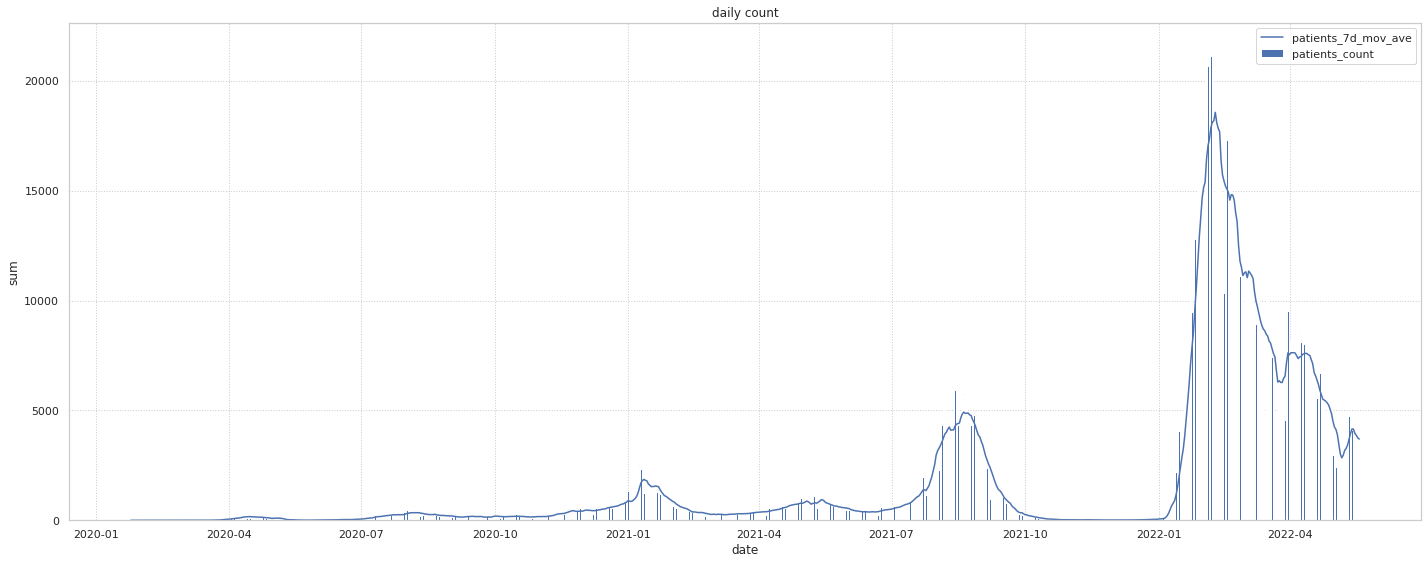

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
831,1.651651e+09,2022,5,4,0,0,0,0,0,0,...,757,364,328.857143,2302.0,0,0.0,0.0,2999,3455.142857,24186.0
832,1.651738e+09,2022,5,5,0,0,0,0,1,0,...,758,398,336.285714,2354.0,0,0.0,0.0,2320,3016.000000,21112.0
833,1.651824e+09,2022,5,6,1,0,0,0,0,0,...,759,402,343.714286,2406.0,0,0.0,0.0,2681,2842.857143,19900.0
834,1.651910e+09,2022,5,7,0,0,1,0,0,0,...,760,460,357.000000,2499.0,0,0.0,0.0,3809,2961.428571,20730.0
835,1.651997e+09,2022,5,8,0,0,0,1,0,0,...,761,381,378.285714,2648.0,0,0.0,0.0,4711,3182.857143,22280.0
836,1.652083e+09,2022,5,9,0,1,0,0,0,0,...,762,373,385.857143,2701.0,0,0.0,0.0,3011,3269.714286,22888.0
837,1.652170e+09,2022,5,10,0,0,0,0,0,1,...,763,332,387.142857,2710.0,0,0.0,0.0,4451,3426.000000,23982.0
838,1.652256e+09,2022,5,11,0,0,0,0,0,0,...,764,311,379.571429,2657.0,0,0.0,0.0,4764,3678.142857,25747.0
839,1.652342e+09,2022,5,12,0,0,0,0,1,0,...,765,304,366.142857,2563.0,0,0.0,0.0,4216,3949.000000,27643.0
840,1.652429e+09,2022,5,13,1,0,0,0,0,0,...,766,295,350.857143,2456.0,0,0.0,0.0,4109,4153.000000,29071.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            846 non-null    float64
 1   year                 846 non-null    int64  
 2   month                846 non-null    int64  
 3   day                  846 non-null    int64  
 4   Fri                  846 non-null    uint8  
 5   Mon                  846 non-null    uint8  
 6   Sat                  846 non-null    uint8  
 7   Sun                  846 non-null    uint8  
 8   Thu                  846 non-null    uint8  
 9   Tue                  846 non-null    uint8  
 10  Wed                  846 non-null    uint8  
 11  passed               846 non-null    int64  
 12  emergency            846 non-null    int64  
 13  em_passed            846 non-null    int64  
 14  contacts_count       846 non-null    int64  
 15  contacts_7d_mov_ave  846 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,8.460000e+02,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,...,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,1.616357e+09,2020.757683,6.067376,15.677305,0.143026,0.143026,0.143026,0.143026,0.141844,0.143026,...,351.780142,674.317967,673.563295,4714.938534,435.601655,435.601655,3049.211584,1775.624113,1762.843347,12339.884161
std,2.111300e+07,0.714454,3.432728,8.810356,0.350306,0.350306,0.350306,0.350306,0.349096,0.350306,...,239.271095,542.732329,530.529861,3713.714759,760.766273,700.807062,4905.649434,3579.846757,3497.111669,24479.791406
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.598105e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,137.250000,331.250000,337.892857,2365.250000,0.000000,0.000000,0.000000,73.500000,86.035714,602.250000
50%,1.616357e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,348.500000,512.500000,524.000000,3668.000000,0.000000,0.000000,0.000000,312.500000,329.642857,2307.500000
75%,1.634609e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,559.750000,807.750000,812.821429,5689.750000,791.500000,991.500000,6940.500000,1027.500000,995.750000,6970.250000
max,1.652861e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,771.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21562.000000,18562.285714,129936.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.915886,0.053010,-0.013145,-0.004182,0.000836,-0.002509,-0.000836,-2.150339e-16,0.002509,...,0.998919,-0.061289,-0.049556,-0.049554,-0.617695,-0.662904,-0.662904,0.552304,0.565242,0.565243
year,9.158860e-01,1.000000,-0.350895,-0.045715,-0.003214,0.001515,0.001515,0.001515,-4.374699e-03,0.001515,...,0.920823,0.045314,0.056912,0.056914,-0.607947,-0.659961,-0.659961,0.658342,0.669012,0.669013
month,5.301037e-02,-0.350895,1.000000,-0.000885,-0.002118,-0.002118,-0.009991,-0.006055,1.077899e-02,0.002802,...,0.038106,-0.258426,-0.258966,-0.258964,0.073291,0.098249,0.098249,-0.351587,-0.347406,-0.347405
day,-1.314488e-02,-0.045715,-0.000885,1.000000,0.004236,0.003469,0.003469,0.003469,1.817438e-03,-0.008035,...,-0.012840,0.018448,0.005664,0.005663,0.010137,0.000638,0.000638,-0.015890,-0.021983,-0.021983
Fri,-4.182002e-03,-0.003214,-0.002118,0.004236,1.000000,-0.166897,-0.166897,-0.166897,-1.660910e-01,-0.166897,...,-0.003818,-0.016896,-0.001157,-0.001157,0.023954,-0.000300,-0.000300,0.016642,-0.001171,-0.001172
Mon,8.364004e-04,0.001515,-0.002118,0.003469,-0.166897,1.000000,-0.166897,-0.166897,-1.660910e-01,-0.166897,...,0.000842,0.039243,-0.000272,-0.000272,0.095528,-0.000300,-0.000300,-0.068890,0.000143,0.000143
Sat,-2.509201e-03,0.001515,-0.009991,0.003469,-0.166897,-0.166897,1.000000,-0.166897,-1.660910e-01,-0.166897,...,-0.002265,0.046968,-0.000809,-0.000808,-0.110864,-0.000300,-0.000300,0.011602,-0.000647,-0.000647
Sun,-8.364004e-04,0.001515,-0.006055,0.003469,-0.166897,-0.166897,-0.166897,1.000000,-1.660910e-01,-0.166897,...,-0.000712,-0.025038,-0.000565,-0.000565,-0.102165,-0.000300,-0.000300,-0.010927,-0.000185,-0.000185
Thu,-2.150339e-16,-0.004375,0.010779,0.001817,-0.166091,-0.166091,-0.166091,-0.166091,1.000000e+00,-0.166091,...,-0.000405,-0.011881,0.002873,0.002874,0.029712,0.001806,0.001806,0.031824,-0.000036,-0.000036
Tue,2.509201e-03,0.001515,0.002802,-0.008035,-0.166897,-0.166897,-0.166897,-0.166897,-1.660910e-01,1.000000,...,0.002395,-0.017058,-0.000032,-0.000031,0.037946,-0.000300,-0.000300,-0.010382,0.000648,0.000648


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,1.652515e+09,0,0,1,0,0,0,0,841,0,767,383,0,3799,4151.571429,29061.0
842,1.652602e+09,0,0,0,1,0,0,0,842,0,768,268,0,3348,3956.857143,27698.0
843,1.652688e+09,0,1,0,0,0,0,0,843,0,769,322,0,2377,3866.285714,27064.0
844,1.652774e+09,0,0,0,0,0,1,0,844,0,770,264,0,3663,3753.714286,26276.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
841,1.652515e+09,841,0,3799,4151.571429,29061.0
842,1.652602e+09,842,0,3348,3956.857143,27698.0
843,1.652688e+09,843,0,2377,3866.285714,27064.0
844,1.652774e+09,844,0,3663,3753.714286,26276.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

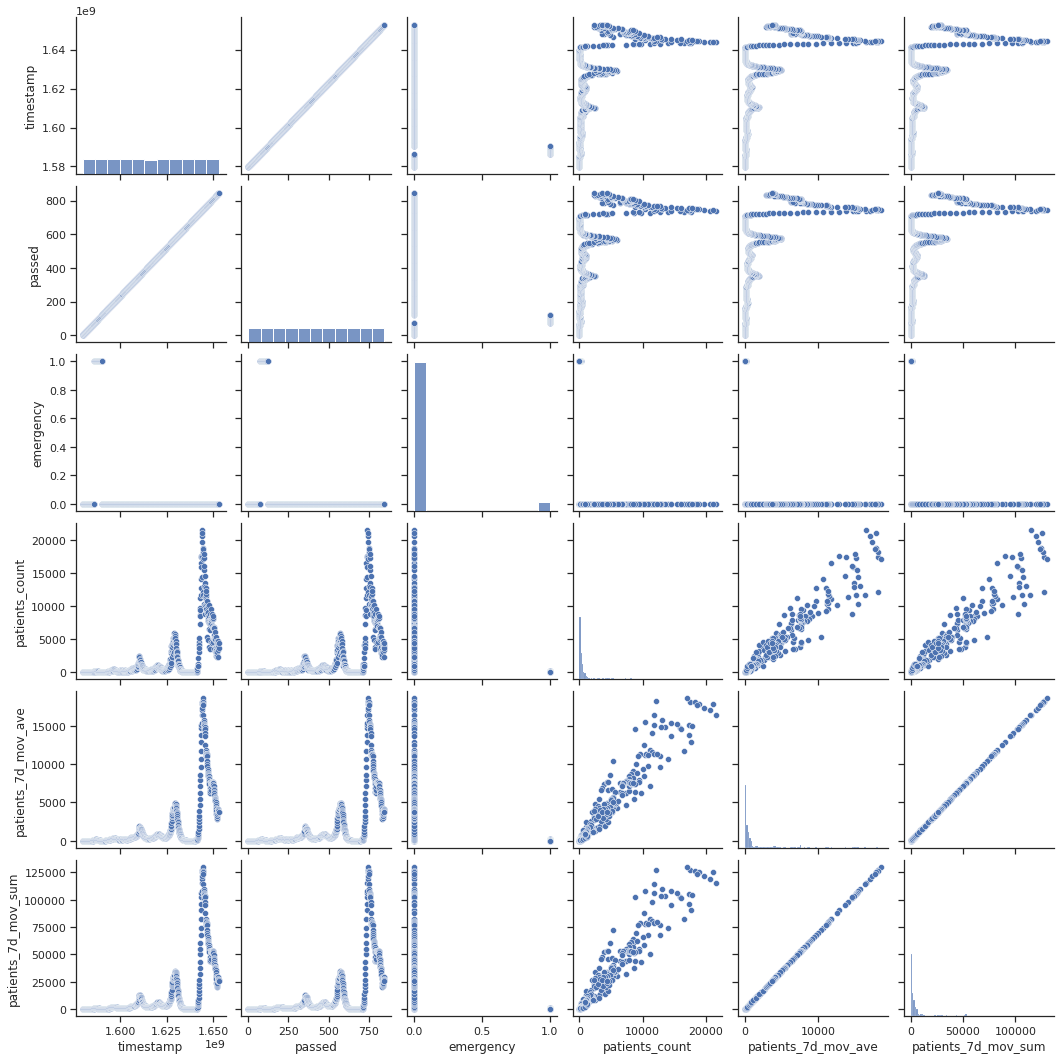

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.29
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=